# Flood Vulnerability Index (FVI) Mapping

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
from functools import reduce
import fhv
from tabula import read_pdf
import fiona
pd.options.mode.chained_assignment = None

In [8]:
# Load data
variable = pd.read_hdf('./data/census.hdf')
variable_table = pd.read_hdf('./data/census_table.hdf')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_upazila['ADM3_PCODE'] = shp_upazila['ADM3_PCODE'].astype(int)
# with fiona.open('./data/adm_upazila.shp', "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]


In [14]:
# Nomalization

## Vulnerability Assessments
### (1) Equal weights 

In [9]:
# Empty vulnerability dataframe
vuln = pd.DataFrame(index=variable.index.astype('int'))

# Equal weights
nind = variable.shape[1]
vuln['equal'] = np.dot(variable.values, np.ones(nind)/nind)

### (2) Random weights

In [11]:
# Sensitivity analysis with random weights
nt = 1000      # Must be a multiple of 100
thsd = 0.55
freq = np.zeros([variable.shape[0],1])
for i in range(nt//100):
    rwgt = np.random.random([variable.shape[1],100])
    rwgt = rwgt/rwgt.sum(axis=0)
    score = np.dot(variable,rwgt)
    freq += (score > thsd).sum(1)[:,None]
vuln_random = freq/nt

# vuln_random = fhv.ValidCellToMap(vuln_random.squeeze(), valid, dtype='float32', nodata=-9999)
# # Temporarily
# vuln_random[vuln_random < 0.7] = -9999
# vulnRand = vuln_random.copy()
# vulnRand[vulnRand>=0.7] = 1
# vulnRand[vulnRand<0.7] = 0
# vulnRand = vulnRand.astype('int8')
# # Saving as GeoTiff
# if True:
#     fhv.GenerateRaster('./data/vulnability_random.tif', meta, vuln_random, 
#                        new_dtype=rasterio.float32, new_nodata=-9999)
#     fhv.GenerateRaster('./data/vulnability_random_logit.tif', meta, vulnRand, 
#                        new_dtype=rasterio.int8, new_nodata=0)

In [13]:
vuln_random.shape

(544, 1)

In [7]:
# Merge all vulnerabilities
map_upazila = pd.merge(shp_upazila, vuln, left_on='ADM3_PCODE', right_on='UID', how='left')
map_upazila

,ADM3_PCODE,ADM3_EN,ADM2_PCODE,ADM2_EN,geometry,equal
0,100409,Amtali,1004,Barguna,(POLYGON ((90.15402190600008 22.12257139300004...,0.346395
1,100419,Bamna,1004,Barguna,"POLYGON ((90.08715094100006 22.34555396000007,...",0.306061
2,100428,Barguna Sadar,1004,Barguna,"POLYGON ((90.17132644500003 22.24123249700006,...",0.318564
3,100447,Betagi,1004,Barguna,"POLYGON ((90.24002197100003 22.48501612000007,...",0.313703
4,100485,Patharghata,1004,Barguna,(POLYGON ((89.87967503300007 22.07868995300004...,0.330078
...,...,...,...,...,...,...
539,609141,Gowainghat,6091,Sylhet,"POLYGON ((92.05021737000004 25.18670148200005,...",0.466127
540,609153,Jaintiapur,6091,Sylhet,"POLYGON ((92.06496186200008 25.18604925000005,...",0.404602
541,609159,Kanaighat,6091,Sylhet,"POLYGON ((92.23743389500004 25.09396688200007,...",0.443371
542,609162,Sylhet Sadar,6091,Sylhet,"POLYGON ((91.77890601400009 25.01136765600006,...",0.283302


### Initialize mapping parameters

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# Colarmap and Colorbar controller
def cbarpam(bounds, color, labloc='on', boundaries=None, extension=None):
    '''Returns parameters for colormap and colorbar objects with a specified style.

        Parameters
        ----------
        bounds: list of bounds
        color: name of colormap or list of color names

        labloc: 'on' or 'in'
        boundaries: 
        extension: 'both', 'min', 'max'

        Return
        ------
        cmap: colormap
        norm: nomalization
        vmin: vmin for plotting
        vmax: vmax for plotting
        boundaries: boundaries for plotting
    '''
    
    gradient = np.linspace(0, 1, len(bounds)+1)
    # Create colorlist
    if type(color) is list:
        cmap = colors.ListedColormap(color,"")
    elif type(color) is str:
        cmap = plt.get_cmap(color, len(gradient))    
        # Extension
        colorsList = list(cmap(np.arange(len(gradient))))
        if extension is 'both':
            cmap = colors.ListedColormap(colorsList[1:-1],"")
            cmap.set_under(colorsList[0])
            cmap.set_over(colorsList[-1])
        elif extension is 'max':
            cmap = colors.ListedColormap(colorsList[:-1],"")
            cmap.set_over(colorsList[-1])
        elif extension is 'min':
            cmap = colors.ListedColormap(colorsList[1:],"")
            cmap.set_under(colorsList[0])
        elif extension is None:
            gradient = np.linspace(0, 1, len(bounds)-1)
            cmap = plt.get_cmap(color, len(gradient))
        else:
            raise ValueError('Check the extension')
    else:
        raise ValueError('Check the type of color.')
    # Normalization
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # vmin and vmax
    vmin=bounds[0]
    vmax=bounds[-1]
    # Ticks
    if labloc == 'on':
        ticks = bounds
    elif labloc == 'in':
        ticks = np.array(bounds)[0:-1] + (np.array(bounds)[1:] - np.array(bounds)[0:-1])/2
    
    return cmap, norm, vmin, vmax, ticks, boundaries

### Mapping with equal weights 

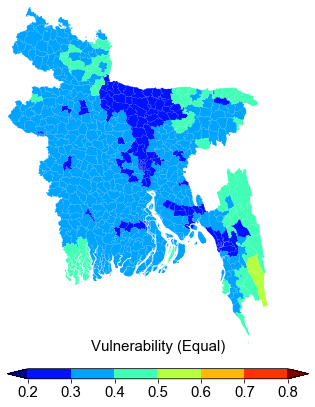

In [6]:
# Mapping
# sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'jet', labloc='on',
                                                    boundaries=boundaries, extension='both')

# Plotting
figlabel = 'Vulnerability (Equal)'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
map_upazila.plot(ax=ax, column='equal', 
        cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)  
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0, -0.1, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=15)
cbar.set_label(figlabel, labelpad=-60, 
               fontname='arial', fontsize=15, 
               horizontalalignment='center')
plt.show()

In [5]:
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1)  # Flood depth (decuple)
# fcst = np.array(fcst >= 20).astype(np.int8).flatten()


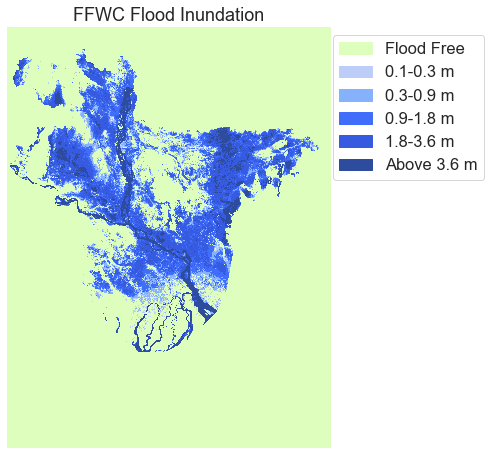

In [45]:
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import seaborn as sns
import fiona
from descartes import PolygonPatch
sns.set(font_scale=1.5, style="white")


# Define the colors
class_bin = np.array([0,1.01,3,9,18,36,100])
class_label = ['Flood Free','0.1-0.3 m','0.3-0.9 m','0.9-1.8 m','1.8-3.6 m','Above 3.6 m']
class_rgb = [[222,254,190],[188,205,247],[134,177,252],[65,109,251],[54,91,224],[45,76,157]]
class_rgb = list(np.array(class_rgb)/255)
cmap = ListedColormap(class_rgb)
cmap.name = class_name
# Define a normalization from values -> colors
norm = colors.BoundaryNorm(class_bin, len(class_bin))

# Plot raster
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7), facecolor='w')
im = ax.imshow(fcst,cmap=cmap,norm=norm)
# Title
ax.set_title("FFWC Flood Inundation")
# Legend
patches = [ mpatches.Patch(color=class_rgb[i],label=class_label[i]) for i in range(len(class_label)) ]
ax.legend(handles=patches,bbox_to_anchor=(1.5, 1),facecolor="white")
# Post-setting
plt.tight_layout()
ax.set_axis_off()
plt.show()